In [9]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_FD import MLP, MLPProjectionFilter

/home/alinjar/simple_training_warm_start


In [10]:
class TrajDataset(Dataset):
	"""Expert Trajectory Dataset."""
	def __init__(self, inp):
		
		# input
		self.inp = inp

	
	def __len__(self):
		return len(self.inp)    
			
	def __getitem__(self, idx):

		# Input
  
		inp = self.inp[idx]
		
				 
		return torch.tensor(inp).float()

In [11]:
def sample_uniform_trajectories(key, v_max, num_batch, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=-v_max,
        high=v_max,
        size=(num_batch, nvar)
    )
    return xi_samples, rng

In [12]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
nvar_single = num_steps
nvar = num_dof * nvar_single

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

xi_samples, rng = sample_uniform_trajectories(42, v_max, num_batch, nvar)

inp = xi_samples

inp_mean, inp_std = inp.mean(), inp.std()

print("inp", inp.shape)

Using cuda device
inp (1000, 50)


In [14]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)



model = MLPProjectionFilter(mlp=mlp,num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							theta_init=theta_init).to(device)

print(type(model))                            

<class 'mlp_singledof_FD.MLPProjectionFilter'>


In [15]:
#Training

epochs = 400
step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-2, weight_decay=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)
losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss = [], [], []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses = [], [], []
    
    for (inp) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        

        _, accumulated_res_fixed_point, accumulated_res_primal, accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp)
        primal_loss, fixed_point_loss, loss = model.mlp_loss(accumulated_res_primal, accumulated_res_fixed_point)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        optimizer.step() #updates the model parameters
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}, primal loss: {np.average(primal_losses):.3f}, fixed_point loss: {np.average(fixed_point_losses):.3f} ")

    #step += 0.07 #0.15
    # scheduler.step()
    
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_proj_manipulator.pth")
            last_loss = loss
    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_fixed_point_loss.append(np.average(fixed_point_losses))

100%|██████████| 1/1 [00:00<00:00, 65.47it/s]


Epoch: 1, Train Loss: 170083.078, primal loss: 126.770, fixed_point loss: 169956.312 


100%|██████████| 1/1 [00:00<00:00, 66.21it/s]


Epoch: 3, Train Loss: 442245.531, primal loss: 305.128, fixed_point loss: 441940.406 


100%|██████████| 1/1 [00:00<00:00, 75.21it/s]


Epoch: 5, Train Loss: 228786.766, primal loss: 159.227, fixed_point loss: 228627.531 


100%|██████████| 1/1 [00:00<00:00, 64.65it/s]


Epoch: 7, Train Loss: 176071.797, primal loss: 127.153, fixed_point loss: 175944.641 


100%|██████████| 1/1 [00:00<00:00, 70.18it/s]


Epoch: 9, Train Loss: 138434.812, primal loss: 98.636, fixed_point loss: 138336.172 


100%|██████████| 1/1 [00:00<00:00, 69.23it/s]


Epoch: 11, Train Loss: 111440.680, primal loss: 81.127, fixed_point loss: 111359.555 


100%|██████████| 1/1 [00:00<00:00, 77.71it/s]


Epoch: 13, Train Loss: 86489.844, primal loss: 62.566, fixed_point loss: 86427.281 


100%|██████████| 1/1 [00:00<00:00, 67.74it/s]


Epoch: 15, Train Loss: 74579.422, primal loss: 54.237, fixed_point loss: 74525.188 


100%|██████████| 1/1 [00:00<00:00, 73.97it/s]


Epoch: 17, Train Loss: 57163.156, primal loss: 42.561, fixed_point loss: 57120.594 


100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


Epoch: 19, Train Loss: 51145.602, primal loss: 38.366, fixed_point loss: 51107.234 


100%|██████████| 1/1 [00:00<00:00, 75.59it/s]


Epoch: 21, Train Loss: 39855.594, primal loss: 30.604, fixed_point loss: 39824.988 


100%|██████████| 1/1 [00:00<00:00, 56.77it/s]


Epoch: 23, Train Loss: 35944.160, primal loss: 27.941, fixed_point loss: 35916.219 


100%|██████████| 1/1 [00:00<00:00, 76.80it/s]


Epoch: 25, Train Loss: 26014.791, primal loss: 20.890, fixed_point loss: 25993.900 


100%|██████████| 1/1 [00:00<00:00, 75.65it/s]


Epoch: 27, Train Loss: 26207.094, primal loss: 21.070, fixed_point loss: 26186.023 


100%|██████████| 1/1 [00:00<00:00, 76.95it/s]


Epoch: 29, Train Loss: 18562.295, primal loss: 15.607, fixed_point loss: 18546.688 


100%|██████████| 1/1 [00:00<00:00, 70.64it/s]


Epoch: 31, Train Loss: 18417.111, primal loss: 15.074, fixed_point loss: 18402.037 


100%|██████████| 1/1 [00:00<00:00, 77.69it/s]


Epoch: 33, Train Loss: 14130.090, primal loss: 11.995, fixed_point loss: 14118.095 


100%|██████████| 1/1 [00:00<00:00, 74.46it/s]


Epoch: 35, Train Loss: 14914.025, primal loss: 12.085, fixed_point loss: 14901.940 


100%|██████████| 1/1 [00:00<00:00, 76.52it/s]


Epoch: 37, Train Loss: 9516.327, primal loss: 8.521, fixed_point loss: 9507.806 


100%|██████████| 1/1 [00:00<00:00, 76.39it/s]


Epoch: 39, Train Loss: 11876.464, primal loss: 9.960, fixed_point loss: 11866.504 


100%|██████████| 1/1 [00:00<00:00, 76.14it/s]


Epoch: 41, Train Loss: 9086.897, primal loss: 8.045, fixed_point loss: 9078.853 


100%|██████████| 1/1 [00:00<00:00, 76.04it/s]


Epoch: 43, Train Loss: 8041.669, primal loss: 7.089, fixed_point loss: 8034.580 


100%|██████████| 1/1 [00:00<00:00, 76.17it/s]


Epoch: 45, Train Loss: 8546.808, primal loss: 7.410, fixed_point loss: 8539.397 


100%|██████████| 1/1 [00:00<00:00, 74.57it/s]


Epoch: 47, Train Loss: 7591.676, primal loss: 6.600, fixed_point loss: 7585.076 


100%|██████████| 1/1 [00:00<00:00, 73.32it/s]


Epoch: 49, Train Loss: 6770.972, primal loss: 6.093, fixed_point loss: 6764.879 


100%|██████████| 1/1 [00:00<00:00, 74.70it/s]


Epoch: 51, Train Loss: 6831.959, primal loss: 6.010, fixed_point loss: 6825.950 


100%|██████████| 1/1 [00:00<00:00, 77.40it/s]


Epoch: 53, Train Loss: 5939.758, primal loss: 5.333, fixed_point loss: 5934.425 


100%|██████████| 1/1 [00:00<00:00, 73.75it/s]


Epoch: 55, Train Loss: 6354.680, primal loss: 5.399, fixed_point loss: 6349.281 


100%|██████████| 1/1 [00:00<00:00, 75.92it/s]


Epoch: 57, Train Loss: 5205.593, primal loss: 4.564, fixed_point loss: 5201.029 


100%|██████████| 1/1 [00:00<00:00, 76.32it/s]


Epoch: 59, Train Loss: 4095.142, primal loss: 3.798, fixed_point loss: 4091.344 


100%|██████████| 1/1 [00:00<00:00, 75.66it/s]


Epoch: 61, Train Loss: 5196.843, primal loss: 4.356, fixed_point loss: 5192.487 


100%|██████████| 1/1 [00:00<00:00, 73.03it/s]


Epoch: 63, Train Loss: 4572.868, primal loss: 3.925, fixed_point loss: 4568.942 


100%|██████████| 1/1 [00:00<00:00, 76.32it/s]


Epoch: 65, Train Loss: 3567.996, primal loss: 3.328, fixed_point loss: 3564.668 


100%|██████████| 1/1 [00:00<00:00, 72.96it/s]


Epoch: 67, Train Loss: 3241.548, primal loss: 2.991, fixed_point loss: 3238.557 


100%|██████████| 1/1 [00:00<00:00, 62.56it/s]


Epoch: 69, Train Loss: 3743.712, primal loss: 3.260, fixed_point loss: 3740.452 


100%|██████████| 1/1 [00:00<00:00, 74.71it/s]


Epoch: 71, Train Loss: 4024.170, primal loss: 3.403, fixed_point loss: 4020.767 


100%|██████████| 1/1 [00:00<00:00, 72.81it/s]


Epoch: 73, Train Loss: 4921.192, primal loss: 3.946, fixed_point loss: 4917.246 


100%|██████████| 1/1 [00:00<00:00, 75.40it/s]


Epoch: 75, Train Loss: 4044.007, primal loss: 3.246, fixed_point loss: 4040.761 


100%|██████████| 1/1 [00:00<00:00, 74.00it/s]


Epoch: 77, Train Loss: 3882.470, primal loss: 3.326, fixed_point loss: 3879.144 


100%|██████████| 1/1 [00:00<00:00, 76.07it/s]


Epoch: 79, Train Loss: 3149.441, primal loss: 2.696, fixed_point loss: 3146.745 


100%|██████████| 1/1 [00:00<00:00, 72.61it/s]


Epoch: 81, Train Loss: 2884.922, primal loss: 2.582, fixed_point loss: 2882.340 


100%|██████████| 1/1 [00:00<00:00, 76.83it/s]


Epoch: 83, Train Loss: 3201.090, primal loss: 2.743, fixed_point loss: 3198.347 


100%|██████████| 1/1 [00:00<00:00, 74.03it/s]


Epoch: 85, Train Loss: 3990.549, primal loss: 3.152, fixed_point loss: 3987.397 


100%|██████████| 1/1 [00:00<00:00, 77.44it/s]


Epoch: 87, Train Loss: 4701.880, primal loss: 3.633, fixed_point loss: 4698.247 


100%|██████████| 1/1 [00:00<00:00, 76.29it/s]


Epoch: 89, Train Loss: 3761.436, primal loss: 2.950, fixed_point loss: 3758.485 


100%|██████████| 1/1 [00:00<00:00, 72.47it/s]


Epoch: 91, Train Loss: 3256.368, primal loss: 2.621, fixed_point loss: 3253.747 


100%|██████████| 1/1 [00:00<00:00, 73.54it/s]


Epoch: 93, Train Loss: 2874.295, primal loss: 2.406, fixed_point loss: 2871.889 


100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch: 95, Train Loss: 2088.265, primal loss: 1.807, fixed_point loss: 2086.458 


100%|██████████| 1/1 [00:00<00:00, 61.81it/s]


Epoch: 97, Train Loss: 2554.512, primal loss: 2.093, fixed_point loss: 2552.419 


100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 99, Train Loss: 3273.456, primal loss: 2.485, fixed_point loss: 3270.971 


100%|██████████| 1/1 [00:00<00:00, 74.81it/s]


Epoch: 101, Train Loss: 2647.813, primal loss: 2.076, fixed_point loss: 2645.737 


100%|██████████| 1/1 [00:00<00:00, 77.35it/s]


Epoch: 103, Train Loss: 2008.730, primal loss: 1.673, fixed_point loss: 2007.057 


100%|██████████| 1/1 [00:00<00:00, 78.10it/s]


Epoch: 105, Train Loss: 2119.110, primal loss: 1.730, fixed_point loss: 2117.380 


100%|██████████| 1/1 [00:00<00:00, 78.36it/s]


Epoch: 107, Train Loss: 2402.127, primal loss: 1.873, fixed_point loss: 2400.253 


100%|██████████| 1/1 [00:00<00:00, 75.38it/s]


Epoch: 109, Train Loss: 2285.825, primal loss: 1.787, fixed_point loss: 2284.039 


100%|██████████| 1/1 [00:00<00:00, 69.06it/s]


Epoch: 111, Train Loss: 1894.453, primal loss: 1.553, fixed_point loss: 1892.899 


100%|██████████| 1/1 [00:00<00:00, 76.39it/s]


Epoch: 113, Train Loss: 1849.518, primal loss: 1.512, fixed_point loss: 1848.006 


100%|██████████| 1/1 [00:00<00:00, 58.92it/s]


Epoch: 115, Train Loss: 2111.302, primal loss: 1.645, fixed_point loss: 2109.657 


100%|██████████| 1/1 [00:00<00:00, 77.50it/s]


Epoch: 117, Train Loss: 2046.853, primal loss: 1.596, fixed_point loss: 2045.257 


100%|██████████| 1/1 [00:00<00:00, 77.25it/s]


Epoch: 119, Train Loss: 1758.644, primal loss: 1.410, fixed_point loss: 1757.234 


100%|██████████| 1/1 [00:00<00:00, 60.14it/s]


Epoch: 121, Train Loss: 1619.356, primal loss: 1.320, fixed_point loss: 1618.036 


100%|██████████| 1/1 [00:00<00:00, 66.13it/s]


Epoch: 123, Train Loss: 1798.412, primal loss: 1.409, fixed_point loss: 1797.003 


100%|██████████| 1/1 [00:00<00:00, 75.58it/s]


Epoch: 125, Train Loss: 1879.224, primal loss: 1.435, fixed_point loss: 1877.790 


100%|██████████| 1/1 [00:00<00:00, 73.80it/s]


Epoch: 127, Train Loss: 1741.852, primal loss: 1.343, fixed_point loss: 1740.509 


100%|██████████| 1/1 [00:00<00:00, 55.76it/s]


Epoch: 129, Train Loss: 1347.836, primal loss: 1.108, fixed_point loss: 1346.728 


100%|██████████| 1/1 [00:00<00:00, 73.13it/s]


Epoch: 131, Train Loss: 1651.966, primal loss: 1.278, fixed_point loss: 1650.688 


100%|██████████| 1/1 [00:00<00:00, 70.68it/s]


Epoch: 133, Train Loss: 1794.484, primal loss: 1.353, fixed_point loss: 1793.132 


100%|██████████| 1/1 [00:00<00:00, 75.75it/s]


Epoch: 135, Train Loss: 1538.925, primal loss: 1.197, fixed_point loss: 1537.728 


100%|██████████| 1/1 [00:00<00:00, 43.38it/s]


Epoch: 137, Train Loss: 1193.007, primal loss: 0.988, fixed_point loss: 1192.019 


100%|██████████| 1/1 [00:00<00:00, 74.80it/s]


Epoch: 139, Train Loss: 1472.368, primal loss: 1.137, fixed_point loss: 1471.231 


100%|██████████| 1/1 [00:00<00:00, 74.77it/s]


Epoch: 141, Train Loss: 1676.163, primal loss: 1.254, fixed_point loss: 1674.909 


100%|██████████| 1/1 [00:00<00:00, 75.65it/s]


Epoch: 143, Train Loss: 1450.215, primal loss: 1.117, fixed_point loss: 1449.098 


100%|██████████| 1/1 [00:00<00:00, 72.90it/s]


Epoch: 145, Train Loss: 1061.446, primal loss: 0.879, fixed_point loss: 1060.566 


100%|██████████| 1/1 [00:00<00:00, 76.55it/s]


Epoch: 147, Train Loss: 1289.591, primal loss: 1.000, fixed_point loss: 1288.591 


100%|██████████| 1/1 [00:00<00:00, 76.45it/s]


Epoch: 149, Train Loss: 1709.184, primal loss: 1.250, fixed_point loss: 1707.933 


100%|██████████| 1/1 [00:00<00:00, 77.27it/s]


Epoch: 151, Train Loss: 1915.152, primal loss: 1.392, fixed_point loss: 1913.760 


100%|██████████| 1/1 [00:00<00:00, 74.30it/s]


Epoch: 153, Train Loss: 2486.028, primal loss: 1.756, fixed_point loss: 2484.272 


100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 155, Train Loss: 2533.931, primal loss: 1.780, fixed_point loss: 2532.151 


100%|██████████| 1/1 [00:00<00:00, 77.45it/s]


Epoch: 157, Train Loss: 1963.396, primal loss: 1.439, fixed_point loss: 1961.957 


100%|██████████| 1/1 [00:00<00:00, 72.49it/s]


Epoch: 159, Train Loss: 1924.541, primal loss: 1.418, fixed_point loss: 1923.123 


100%|██████████| 1/1 [00:00<00:00, 70.59it/s]


Epoch: 161, Train Loss: 1848.196, primal loss: 1.361, fixed_point loss: 1846.835 


100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


Epoch: 163, Train Loss: 1534.878, primal loss: 1.150, fixed_point loss: 1533.729 


100%|██████████| 1/1 [00:00<00:00, 69.75it/s]


Epoch: 165, Train Loss: 1344.513, primal loss: 1.007, fixed_point loss: 1343.507 


100%|██████████| 1/1 [00:00<00:00, 76.40it/s]


Epoch: 167, Train Loss: 1522.655, primal loss: 1.123, fixed_point loss: 1521.532 


100%|██████████| 1/1 [00:00<00:00, 78.48it/s]


Epoch: 169, Train Loss: 1888.989, primal loss: 1.357, fixed_point loss: 1887.632 


100%|██████████| 1/1 [00:00<00:00, 75.17it/s]


Epoch: 171, Train Loss: 1805.883, primal loss: 1.312, fixed_point loss: 1804.571 


100%|██████████| 1/1 [00:00<00:00, 75.44it/s]


Epoch: 173, Train Loss: 1373.999, primal loss: 1.034, fixed_point loss: 1372.965 


100%|██████████| 1/1 [00:00<00:00, 75.46it/s]


Epoch: 175, Train Loss: 1300.829, primal loss: 0.976, fixed_point loss: 1299.852 


100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


Epoch: 177, Train Loss: 1227.373, primal loss: 0.927, fixed_point loss: 1226.447 


100%|██████████| 1/1 [00:00<00:00, 76.21it/s]


Epoch: 179, Train Loss: 1248.470, primal loss: 0.925, fixed_point loss: 1247.545 


100%|██████████| 1/1 [00:00<00:00, 61.86it/s]


Epoch: 181, Train Loss: 1522.965, primal loss: 1.090, fixed_point loss: 1521.875 


100%|██████████| 1/1 [00:00<00:00, 75.91it/s]


Epoch: 183, Train Loss: 1210.390, primal loss: 0.903, fixed_point loss: 1209.487 


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 185, Train Loss: 1020.901, primal loss: 0.783, fixed_point loss: 1020.118 


100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch: 187, Train Loss: 1196.865, primal loss: 0.887, fixed_point loss: 1195.978 


100%|██████████| 1/1 [00:00<00:00, 66.44it/s]


Epoch: 189, Train Loss: 1305.262, primal loss: 0.952, fixed_point loss: 1304.310 


100%|██████████| 1/1 [00:00<00:00, 67.90it/s]


Epoch: 191, Train Loss: 1129.509, primal loss: 0.840, fixed_point loss: 1128.669 


100%|██████████| 1/1 [00:00<00:00, 68.53it/s]


Epoch: 193, Train Loss: 1011.424, primal loss: 0.764, fixed_point loss: 1010.659 


100%|██████████| 1/1 [00:00<00:00, 68.05it/s]


Epoch: 195, Train Loss: 1113.638, primal loss: 0.821, fixed_point loss: 1112.817 


100%|██████████| 1/1 [00:00<00:00, 60.50it/s]


Epoch: 197, Train Loss: 1218.761, primal loss: 0.880, fixed_point loss: 1217.882 


100%|██████████| 1/1 [00:00<00:00, 59.99it/s]


Epoch: 199, Train Loss: 1052.196, primal loss: 0.771, fixed_point loss: 1051.424 


100%|██████████| 1/1 [00:00<00:00, 62.50it/s]


Epoch: 201, Train Loss: 845.559, primal loss: 0.650, fixed_point loss: 844.909 


100%|██████████| 1/1 [00:00<00:00, 71.60it/s]


Epoch: 203, Train Loss: 931.784, primal loss: 0.699, fixed_point loss: 931.085 


100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


Epoch: 205, Train Loss: 1121.620, primal loss: 0.811, fixed_point loss: 1120.809 


100%|██████████| 1/1 [00:00<00:00, 70.01it/s]


Epoch: 207, Train Loss: 844.858, primal loss: 0.639, fixed_point loss: 844.219 


100%|██████████| 1/1 [00:00<00:00, 70.48it/s]


Epoch: 209, Train Loss: 863.524, primal loss: 0.647, fixed_point loss: 862.877 


100%|██████████| 1/1 [00:00<00:00, 53.16it/s]


Epoch: 211, Train Loss: 917.235, primal loss: 0.679, fixed_point loss: 916.556 


100%|██████████| 1/1 [00:00<00:00, 71.42it/s]


Epoch: 213, Train Loss: 824.391, primal loss: 0.622, fixed_point loss: 823.769 


100%|██████████| 1/1 [00:00<00:00, 73.59it/s]


Epoch: 215, Train Loss: 860.814, primal loss: 0.646, fixed_point loss: 860.168 


100%|██████████| 1/1 [00:00<00:00, 67.11it/s]


Epoch: 217, Train Loss: 820.705, primal loss: 0.618, fixed_point loss: 820.087 


100%|██████████| 1/1 [00:00<00:00, 47.76it/s]


Epoch: 219, Train Loss: 793.796, primal loss: 0.597, fixed_point loss: 793.199 


100%|██████████| 1/1 [00:00<00:00, 65.38it/s]


Epoch: 221, Train Loss: 784.825, primal loss: 0.590, fixed_point loss: 784.235 


100%|██████████| 1/1 [00:00<00:00, 70.12it/s]


Epoch: 223, Train Loss: 753.834, primal loss: 0.568, fixed_point loss: 753.266 


100%|██████████| 1/1 [00:00<00:00, 66.62it/s]


Epoch: 225, Train Loss: 746.511, primal loss: 0.561, fixed_point loss: 745.950 


100%|██████████| 1/1 [00:00<00:00, 69.69it/s]


Epoch: 227, Train Loss: 683.257, primal loss: 0.521, fixed_point loss: 682.736 


100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


Epoch: 229, Train Loss: 727.189, primal loss: 0.546, fixed_point loss: 726.643 


100%|██████████| 1/1 [00:00<00:00, 70.20it/s]


Epoch: 231, Train Loss: 684.661, primal loss: 0.516, fixed_point loss: 684.146 


100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


Epoch: 233, Train Loss: 732.805, primal loss: 0.545, fixed_point loss: 732.260 


100%|██████████| 1/1 [00:00<00:00, 70.72it/s]


Epoch: 235, Train Loss: 658.969, primal loss: 0.502, fixed_point loss: 658.467 


100%|██████████| 1/1 [00:00<00:00, 64.42it/s]


Epoch: 237, Train Loss: 620.213, primal loss: 0.473, fixed_point loss: 619.740 


100%|██████████| 1/1 [00:00<00:00, 71.02it/s]


Epoch: 239, Train Loss: 608.685, primal loss: 0.468, fixed_point loss: 608.217 


100%|██████████| 1/1 [00:00<00:00, 69.72it/s]


Epoch: 241, Train Loss: 639.049, primal loss: 0.482, fixed_point loss: 638.567 


100%|██████████| 1/1 [00:00<00:00, 63.10it/s]


Epoch: 243, Train Loss: 685.412, primal loss: 0.507, fixed_point loss: 684.905 


100%|██████████| 1/1 [00:00<00:00, 71.73it/s]


Epoch: 245, Train Loss: 580.905, primal loss: 0.449, fixed_point loss: 580.456 


100%|██████████| 1/1 [00:00<00:00, 67.42it/s]


Epoch: 247, Train Loss: 523.710, primal loss: 0.416, fixed_point loss: 523.294 


100%|██████████| 1/1 [00:00<00:00, 70.08it/s]


Epoch: 249, Train Loss: 578.623, primal loss: 0.448, fixed_point loss: 578.175 


100%|██████████| 1/1 [00:00<00:00, 47.91it/s]


Epoch: 251, Train Loss: 568.149, primal loss: 0.435, fixed_point loss: 567.714 


100%|██████████| 1/1 [00:00<00:00, 68.89it/s]


Epoch: 253, Train Loss: 668.465, primal loss: 0.489, fixed_point loss: 667.976 


100%|██████████| 1/1 [00:00<00:00, 71.30it/s]


Epoch: 255, Train Loss: 539.512, primal loss: 0.411, fixed_point loss: 539.101 


100%|██████████| 1/1 [00:00<00:00, 42.34it/s]


Epoch: 257, Train Loss: 453.427, primal loss: 0.360, fixed_point loss: 453.067 


100%|██████████| 1/1 [00:00<00:00, 71.03it/s]


Epoch: 259, Train Loss: 542.870, primal loss: 0.417, fixed_point loss: 542.453 


100%|██████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch: 261, Train Loss: 469.098, primal loss: 0.369, fixed_point loss: 468.730 


100%|██████████| 1/1 [00:00<00:00, 71.65it/s]


Epoch: 263, Train Loss: 606.935, primal loss: 0.448, fixed_point loss: 606.487 


100%|██████████| 1/1 [00:00<00:00, 70.90it/s]


Epoch: 265, Train Loss: 539.951, primal loss: 0.409, fixed_point loss: 539.542 


100%|██████████| 1/1 [00:00<00:00, 66.55it/s]


Epoch: 267, Train Loss: 404.648, primal loss: 0.325, fixed_point loss: 404.323 


100%|██████████| 1/1 [00:00<00:00, 60.38it/s]


Epoch: 269, Train Loss: 475.003, primal loss: 0.368, fixed_point loss: 474.635 


100%|██████████| 1/1 [00:00<00:00, 66.93it/s]


Epoch: 271, Train Loss: 503.588, primal loss: 0.382, fixed_point loss: 503.206 


100%|██████████| 1/1 [00:00<00:00, 68.33it/s]


Epoch: 273, Train Loss: 604.580, primal loss: 0.444, fixed_point loss: 604.136 


100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Epoch: 275, Train Loss: 451.431, primal loss: 0.345, fixed_point loss: 451.086 


100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


Epoch: 277, Train Loss: 365.932, primal loss: 0.294, fixed_point loss: 365.639 


100%|██████████| 1/1 [00:00<00:00, 63.13it/s]


Epoch: 279, Train Loss: 481.940, primal loss: 0.369, fixed_point loss: 481.571 


100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


Epoch: 281, Train Loss: 368.934, primal loss: 0.291, fixed_point loss: 368.643 


100%|██████████| 1/1 [00:00<00:00, 71.00it/s]


Epoch: 283, Train Loss: 446.139, primal loss: 0.334, fixed_point loss: 445.805 


100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 285, Train Loss: 409.832, primal loss: 0.314, fixed_point loss: 409.518 


100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


Epoch: 287, Train Loss: 399.499, primal loss: 0.305, fixed_point loss: 399.194 


100%|██████████| 1/1 [00:00<00:00, 69.91it/s]


Epoch: 289, Train Loss: 483.731, primal loss: 0.352, fixed_point loss: 483.379 


100%|██████████| 1/1 [00:00<00:00, 67.02it/s]


Epoch: 291, Train Loss: 542.648, primal loss: 0.391, fixed_point loss: 542.257 


100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch: 293, Train Loss: 395.680, primal loss: 0.301, fixed_point loss: 395.379 


100%|██████████| 1/1 [00:00<00:00, 69.05it/s]


Epoch: 295, Train Loss: 370.265, primal loss: 0.281, fixed_point loss: 369.984 


100%|██████████| 1/1 [00:00<00:00, 67.89it/s]


Epoch: 297, Train Loss: 372.343, primal loss: 0.284, fixed_point loss: 372.059 


100%|██████████| 1/1 [00:00<00:00, 56.85it/s]


Epoch: 299, Train Loss: 351.220, primal loss: 0.268, fixed_point loss: 350.951 


100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


Epoch: 301, Train Loss: 301.499, primal loss: 0.239, fixed_point loss: 301.260 


100%|██████████| 1/1 [00:00<00:00, 61.78it/s]


Epoch: 303, Train Loss: 287.273, primal loss: 0.233, fixed_point loss: 287.040 


100%|██████████| 1/1 [00:00<00:00, 70.20it/s]


Epoch: 305, Train Loss: 304.933, primal loss: 0.243, fixed_point loss: 304.691 


100%|██████████| 1/1 [00:00<00:00, 70.67it/s]


Epoch: 307, Train Loss: 297.950, primal loss: 0.248, fixed_point loss: 297.702 


100%|██████████| 1/1 [00:00<00:00, 69.48it/s]


Epoch: 309, Train Loss: 245.622, primal loss: 0.208, fixed_point loss: 245.414 


100%|██████████| 1/1 [00:00<00:00, 70.73it/s]


Epoch: 311, Train Loss: 279.423, primal loss: 0.223, fixed_point loss: 279.200 


100%|██████████| 1/1 [00:00<00:00, 68.69it/s]


Epoch: 313, Train Loss: 351.980, primal loss: 0.281, fixed_point loss: 351.699 


100%|██████████| 1/1 [00:00<00:00, 67.35it/s]


Epoch: 315, Train Loss: 300.561, primal loss: 0.250, fixed_point loss: 300.311 


100%|██████████| 1/1 [00:00<00:00, 67.99it/s]


Epoch: 317, Train Loss: 287.472, primal loss: 0.230, fixed_point loss: 287.243 


100%|██████████| 1/1 [00:00<00:00, 58.77it/s]


Epoch: 319, Train Loss: 315.844, primal loss: 0.243, fixed_point loss: 315.600 


100%|██████████| 1/1 [00:00<00:00, 68.72it/s]


Epoch: 321, Train Loss: 370.627, primal loss: 0.280, fixed_point loss: 370.346 


100%|██████████| 1/1 [00:00<00:00, 40.17it/s]


Epoch: 323, Train Loss: 247.911, primal loss: 0.202, fixed_point loss: 247.709 


100%|██████████| 1/1 [00:00<00:00, 55.87it/s]


Epoch: 325, Train Loss: 293.671, primal loss: 0.231, fixed_point loss: 293.440 


100%|██████████| 1/1 [00:00<00:00, 62.10it/s]


Epoch: 327, Train Loss: 287.492, primal loss: 0.225, fixed_point loss: 287.267 


100%|██████████| 1/1 [00:00<00:00, 71.24it/s]


Epoch: 329, Train Loss: 263.447, primal loss: 0.211, fixed_point loss: 263.235 


100%|██████████| 1/1 [00:00<00:00, 72.03it/s]


Epoch: 331, Train Loss: 337.119, primal loss: 0.252, fixed_point loss: 336.867 


100%|██████████| 1/1 [00:00<00:00, 76.26it/s]


Epoch: 333, Train Loss: 233.966, primal loss: 0.189, fixed_point loss: 233.777 


100%|██████████| 1/1 [00:00<00:00, 63.48it/s]


Epoch: 335, Train Loss: 239.486, primal loss: 0.190, fixed_point loss: 239.296 


100%|██████████| 1/1 [00:00<00:00, 67.97it/s]


Epoch: 337, Train Loss: 248.773, primal loss: 0.194, fixed_point loss: 248.579 


100%|██████████| 1/1 [00:00<00:00, 71.43it/s]


Epoch: 339, Train Loss: 241.294, primal loss: 0.191, fixed_point loss: 241.104 


100%|██████████| 1/1 [00:00<00:00, 77.16it/s]


Epoch: 341, Train Loss: 256.830, primal loss: 0.201, fixed_point loss: 256.629 


100%|██████████| 1/1 [00:00<00:00, 74.84it/s]


Epoch: 343, Train Loss: 342.000, primal loss: 0.256, fixed_point loss: 341.745 


100%|██████████| 1/1 [00:00<00:00, 72.36it/s]


Epoch: 345, Train Loss: 283.779, primal loss: 0.226, fixed_point loss: 283.554 


100%|██████████| 1/1 [00:00<00:00, 66.11it/s]


Epoch: 347, Train Loss: 272.960, primal loss: 0.220, fixed_point loss: 272.740 


100%|██████████| 1/1 [00:00<00:00, 72.17it/s]


Epoch: 349, Train Loss: 256.150, primal loss: 0.208, fixed_point loss: 255.942 


100%|██████████| 1/1 [00:00<00:00, 72.08it/s]


Epoch: 351, Train Loss: 204.108, primal loss: 0.167, fixed_point loss: 203.941 


100%|██████████| 1/1 [00:00<00:00, 74.45it/s]


Epoch: 353, Train Loss: 146.424, primal loss: 0.129, fixed_point loss: 146.296 


100%|██████████| 1/1 [00:00<00:00, 68.26it/s]


Epoch: 355, Train Loss: 241.478, primal loss: 0.206, fixed_point loss: 241.271 


100%|██████████| 1/1 [00:00<00:00, 65.94it/s]


Epoch: 357, Train Loss: 277.346, primal loss: 0.224, fixed_point loss: 277.122 


100%|██████████| 1/1 [00:00<00:00, 57.51it/s]


Epoch: 359, Train Loss: 251.307, primal loss: 0.202, fixed_point loss: 251.105 


100%|██████████| 1/1 [00:00<00:00, 56.96it/s]


Epoch: 361, Train Loss: 233.212, primal loss: 0.185, fixed_point loss: 233.028 


100%|██████████| 1/1 [00:00<00:00, 69.31it/s]


Epoch: 363, Train Loss: 178.792, primal loss: 0.152, fixed_point loss: 178.641 


100%|██████████| 1/1 [00:00<00:00, 63.90it/s]


Epoch: 365, Train Loss: 227.361, primal loss: 0.183, fixed_point loss: 227.178 


100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


Epoch: 367, Train Loss: 323.198, primal loss: 0.241, fixed_point loss: 322.957 


100%|██████████| 1/1 [00:00<00:00, 44.34it/s]


Epoch: 369, Train Loss: 300.562, primal loss: 0.227, fixed_point loss: 300.336 


100%|██████████| 1/1 [00:00<00:00, 62.03it/s]


Epoch: 371, Train Loss: 277.774, primal loss: 0.209, fixed_point loss: 277.565 


100%|██████████| 1/1 [00:00<00:00, 70.24it/s]


Epoch: 373, Train Loss: 274.920, primal loss: 0.210, fixed_point loss: 274.710 


100%|██████████| 1/1 [00:00<00:00, 64.06it/s]


Epoch: 375, Train Loss: 304.031, primal loss: 0.230, fixed_point loss: 303.802 


100%|██████████| 1/1 [00:00<00:00, 62.27it/s]


Epoch: 377, Train Loss: 324.798, primal loss: 0.241, fixed_point loss: 324.557 


100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


Epoch: 379, Train Loss: 288.201, primal loss: 0.216, fixed_point loss: 287.984 


100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 381, Train Loss: 279.810, primal loss: 0.212, fixed_point loss: 279.598 


100%|██████████| 1/1 [00:00<00:00, 70.58it/s]


Epoch: 383, Train Loss: 313.103, primal loss: 0.230, fixed_point loss: 312.873 


100%|██████████| 1/1 [00:00<00:00, 67.99it/s]


Epoch: 385, Train Loss: 267.364, primal loss: 0.203, fixed_point loss: 267.161 


100%|██████████| 1/1 [00:00<00:00, 67.75it/s]


Epoch: 387, Train Loss: 267.049, primal loss: 0.203, fixed_point loss: 266.846 


100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 389, Train Loss: 251.710, primal loss: 0.193, fixed_point loss: 251.518 


100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Epoch: 391, Train Loss: 243.818, primal loss: 0.184, fixed_point loss: 243.634 


100%|██████████| 1/1 [00:00<00:00, 67.64it/s]


Epoch: 393, Train Loss: 260.950, primal loss: 0.196, fixed_point loss: 260.754 


100%|██████████| 1/1 [00:00<00:00, 59.74it/s]


Epoch: 395, Train Loss: 256.845, primal loss: 0.196, fixed_point loss: 256.649 


100%|██████████| 1/1 [00:00<00:00, 64.21it/s]


Epoch: 397, Train Loss: 218.911, primal loss: 0.166, fixed_point loss: 218.746 


100%|██████████| 1/1 [00:00<00:00, 68.03it/s]


Epoch: 399, Train Loss: 229.481, primal loss: 0.173, fixed_point loss: 229.308 


100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


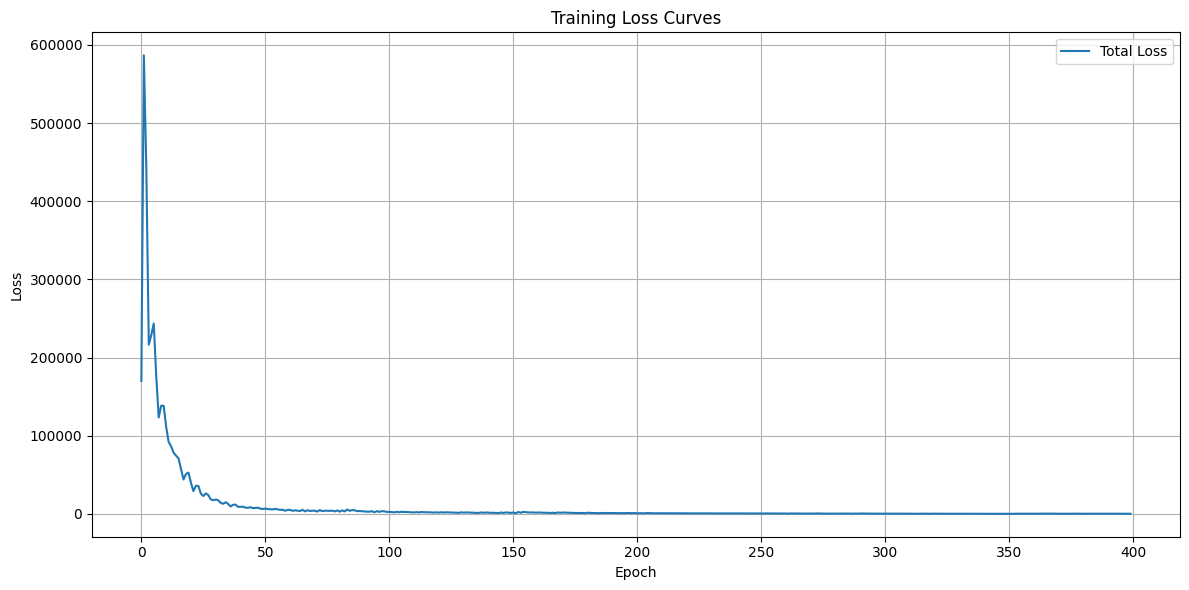

In [18]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
# plt.plot(avg_primal_loss, label='Primal Loss')
# plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')

plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()